In [7]:
## Weather Project
# === Part 1: Analysis and Visualization ===

# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Import the dataset
data = pd.read_csv("C:\\Users\\39392\\Desktop\\DSE\\1ST YEAR\\PYTHON\\projectpython\\weather_project\\data\\GlobalLandTemperaturesByCity.csv")

# Data exploration
print("=== Initial Data Exploration ===")

# Display the first few rows to understand the dataset
print("First few rows of the dataset:")
print(data.head())

=== Initial Data Exploration ===
First few rows of the dataset:
           dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E  


=== Initial Data Exploration ===
First few rows of the dataset:
           dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   
2  1744-01-01                 NaN                            NaN  Århus   
3  1744-02-01                 NaN                            NaN  Århus   
4  1744-03-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E  
2  Denmark   57.05N    10.33E  
3  Denmark   57.05N    10.33E  
4  Denmark   57.05N    10.33E  

Number of missing values per column:
dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude      

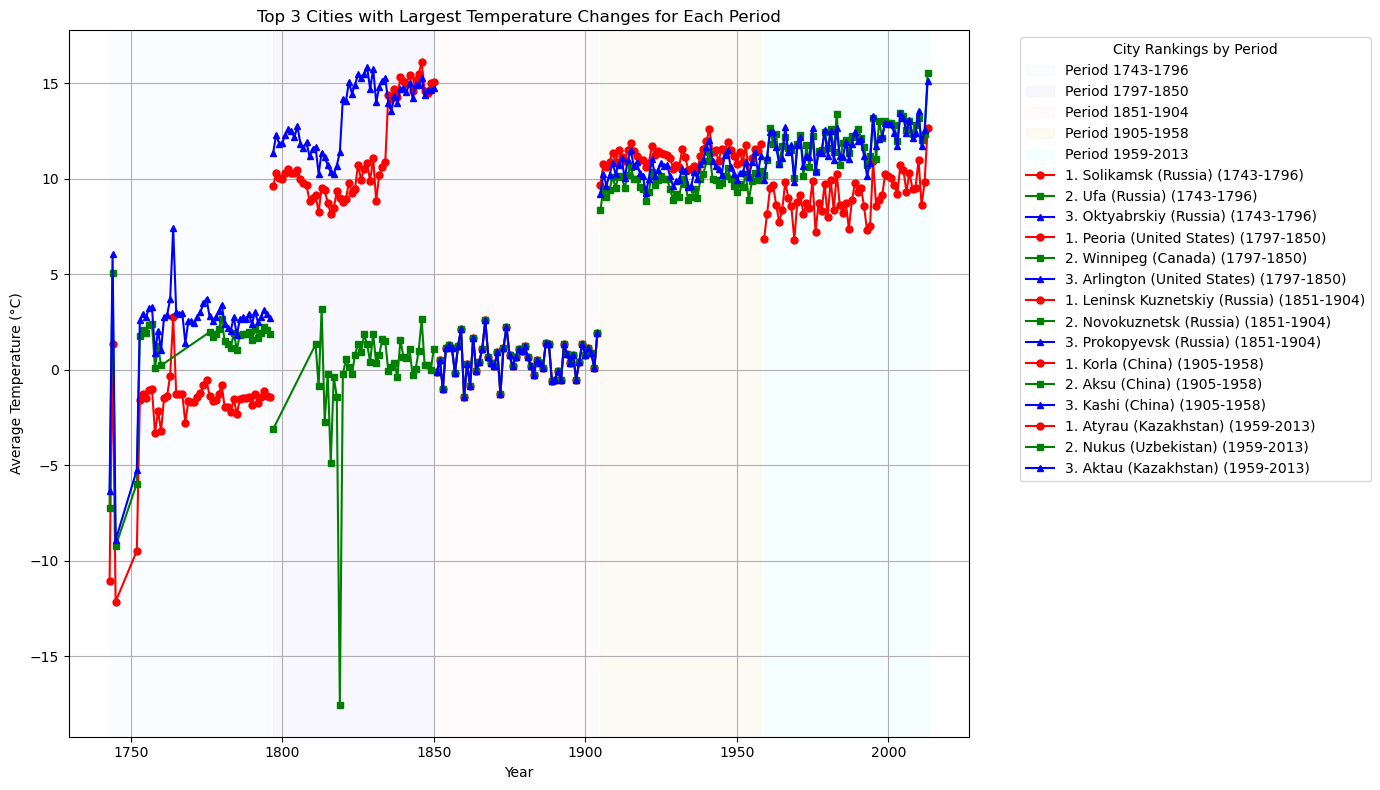

Enter the start year (1743-1993, 20-year range): 1900


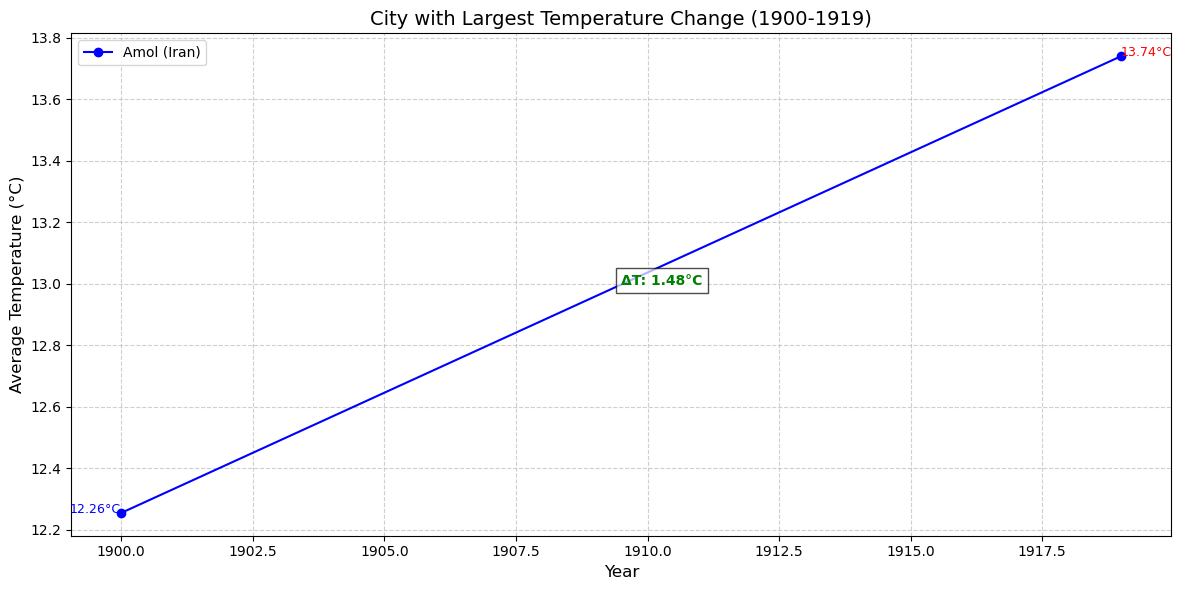


Standard deviation of temperatures by city:
       City  Country  TemperatureStd
0  A Coruña    Spain        3.891411
1    Aachen  Germany        6.370279
2   Aalborg  Denmark        6.557405
3       Aba  Nigeria        1.103028
4    Abadan     Iran        8.350143


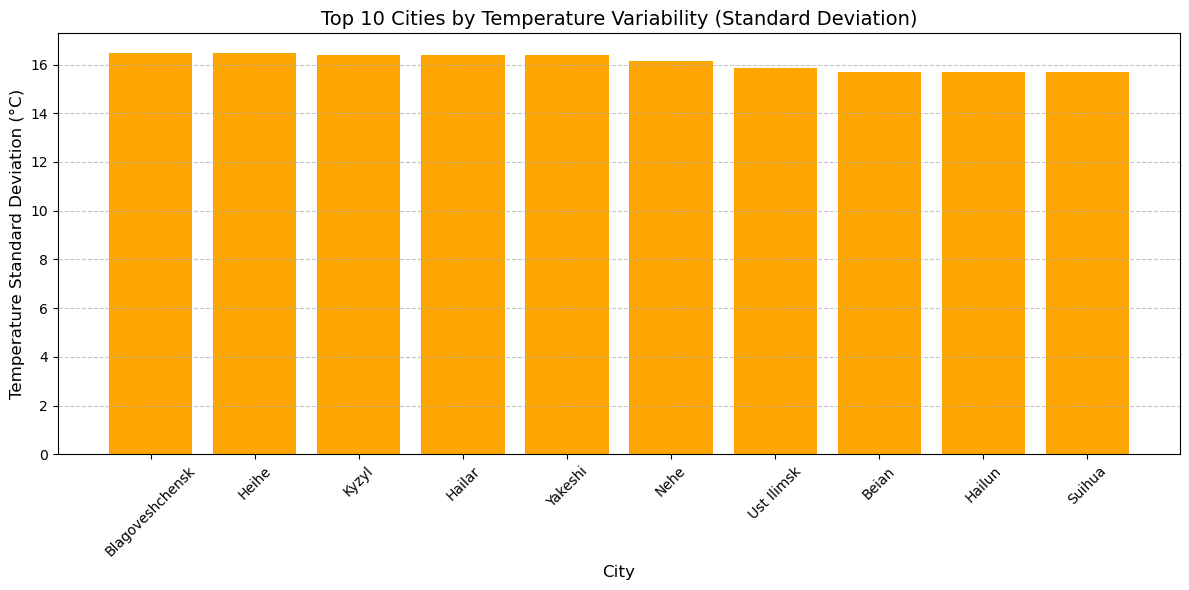

In [5]:


# Check for missing values in each column
print("\nNumber of missing values per column:")
print(data.isnull().sum())

# Data cleaning
# Remove rows with missing temperature data and create a copy of the cleaned data
data_cleaned = data.dropna(subset=['AverageTemperature', 'AverageTemperatureUncertainty']).copy()

# Convert the 'dt' column to datetime format
data_cleaned['dt'] = pd.to_datetime(data_cleaned['dt'], errors='coerce')

# Ensure all dates are valid
if data_cleaned['dt'].isnull().sum() > 0:
    print("\nWarning: Invalid dates found after conversion.")
else:
    print("\nDate conversion successful. No invalid dates found.")

# Convert 'Latitude' and 'Longitude' to numeric values
data_cleaned['Latitude'] = data_cleaned['Latitude'].apply(
    lambda x: float(x[:-1]) * (-1 if 'S' in x or 'W' in x else 1)
)
data_cleaned['Longitude'] = data_cleaned['Longitude'].apply(
    lambda x: float(x[:-1]) * (-1 if 'S' in x or 'W' in x else 1)
)

# Extract the year from the 'dt' column
data_cleaned['Year'] = data_cleaned['dt'].dt.year

# Dataset overview
print("\n=== Cleaned Dataset Overview ===")

# Check the data types and null values
print("Data types and null values:")
print(data_cleaned.dtypes)

# Determine the temporal range of the dataset
first_year = data_cleaned['Year'].min()
last_year = data_cleaned['Year'].max()
print(f"\nThe dataset covers the period from {first_year} to {last_year}.")



# Part 1.1: First Graph - Top 3 Cities with Largest Temperature Changes Across 5 Historical Periods

# Calculate the annual average temperature for each city
annual_avg_temp = data_cleaned.groupby(['City', 'Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Define five historical periods (each spanning 54 years)
periods = {
    "1743-1796": (1743, 1796),
    "1797-1850": (1797, 1850),
    "1851-1904": (1851, 1904),
    "1905-1958": (1905, 1958),
    "1959-2013": (1959, 2013)
}

# Calculate the temperature change for each period and get the top 3 cities with the largest changes
top_cities_by_period = {}

for period_name, (start_year, end_year) in periods.items():
    # Filter data for the specific period
    period_data = annual_avg_temp[(annual_avg_temp['Year'] >= start_year) & (annual_avg_temp['Year'] <= end_year)]
    
    # Calculate the average temperature at the start and end of the period
    temp_start = period_data[period_data['Year'] == start_year].set_index(['City', 'Country'])['AverageTemperature']
    temp_end = period_data[period_data['Year'] == end_year].set_index(['City', 'Country'])['AverageTemperature']
    
    # Merge start and end temperatures to calculate temperature changes
    temp_change = pd.merge(temp_start, temp_end, left_index=True, right_index=True, suffixes=('_start', '_end'))
    temp_change['TemperatureChange'] = temp_change['AverageTemperature_end'] - temp_change['AverageTemperature_start']
    temp_change.reset_index(inplace=True)
    
    # Select the top 3 cities with the largest temperature changes
    top_cities = temp_change.nlargest(3, 'TemperatureChange')
    top_cities_by_period[period_name] = top_cities

# Prepare the graph
plt.figure(figsize=(14, 8))

# Colors and markers for ranked cities (1st, 2nd, 3rd)
colors = ['red', 'green', 'blue']
markers = ['o', 's', '^']

# Add background for each period with distinct colors
period_colors = ['#f0f8ff', '#e6e6fa', '#fff0f5', '#f5f5dc', '#e0ffff']
for i, (period_name, (start_year, end_year)) in enumerate(periods.items()):
    plt.axvspan(start_year, end_year, color=period_colors[i], alpha=0.3, label=f"Period {period_name}")

# Plot lines for each city and period
for i, (period_name, top_cities) in enumerate(top_cities_by_period.items()):
    for rank, (_, row) in enumerate(top_cities.iterrows()):
        city = row['City']
        country = row['Country']
        
        # Filter annual data for the current city and period
        city_data = annual_avg_temp[(annual_avg_temp['City'] == city) & 
                                    (annual_avg_temp['Country'] == country) & 
                                    (annual_avg_temp['Year'] >= periods[period_name][0]) & 
                                    (annual_avg_temp['Year'] <= periods[period_name][1])]
        
        # Plot the city's annual average temperature for the period with country name in the legend
        plt.plot(city_data['Year'], city_data['AverageTemperature'], 
                 label=f"{rank + 1}. {city} ({country}) ({period_name})", 
                 color=colors[rank], marker=markers[rank], 
                 markersize=5, linestyle='-', linewidth=1.5)

# Customize the graph
plt.title("Top 3 Cities with Largest Temperature Changes for Each Period")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.legend(title="City Rankings by Period", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()

# Show the graph
plt.show()

# Part 1.2: Second Graph - City with Largest Temperature Change Over a 20-Year Period

# Function to get a user-defined 20-year period
def get_user_period():
    while True:
        try:
            start_year = int(input("Enter the start year (1743-1993, 20-year range): "))
            if 1743 <= start_year <= 1993:
                return start_year, start_year + 19
            else:
                print("Please enter a valid start year between 1743 and 1993.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

# Function to calculate and plot the city with the largest temperature range
def plot_largest_temperature_range(data_cleaned, start_year, end_year):
    # Filter data for the specified period
    period_data = data_cleaned[(data_cleaned['Year'] >= start_year) & (data_cleaned['Year'] <= end_year)]
    
    # Calculate average temperature at the start and end of the period for each city
    first_year_avg = period_data[period_data['Year'] == start_year].groupby(['City', 'Country'])['AverageTemperature'].mean()
    last_year_avg = period_data[period_data['Year'] == end_year].groupby(['City', 'Country'])['AverageTemperature'].mean()
    
    # Merge and compute temperature changes
    temp_change = pd.merge(first_year_avg, last_year_avg, left_index=True, right_index=True, suffixes=('_start', '_end'))
    temp_change['TemperatureChange'] = temp_change['AverageTemperature_end'] - temp_change['AverageTemperature_start']
    temp_change.reset_index(inplace=True)
    
    # Select the city with the largest temperature change
    largest_change_city = temp_change.nlargest(1, 'TemperatureChange')
    
    if largest_change_city.empty:
        print("No complete data available for the selected period.")
        return

    # Extract details for the selected city
    city = largest_change_city.iloc[0]['City']
    country = largest_change_city.iloc[0]['Country']
    temp_start = largest_change_city.iloc[0]['AverageTemperature_start']
    temp_end = largest_change_city.iloc[0]['AverageTemperature_end']
    temp_change_value = largest_change_city.iloc[0]['TemperatureChange']
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot([start_year, end_year], [temp_start, temp_end], marker='o', color='blue', label=f"{city} ({country})")
    plt.text(start_year, temp_start, f"{temp_start:.2f}°C", fontsize=9, color='blue', ha='right')
    plt.text(end_year, temp_end, f"{temp_end:.2f}°C", fontsize=9, color='red', ha='left')
    plt.text((start_year + end_year) / 2, (temp_start + temp_end) / 2,
             f"ΔT: {temp_change_value:.2f}°C", fontsize=10, fontweight='bold', color='green', 
             bbox=dict(facecolor='white', alpha=0.7))
    
    # Customize the graph
    plt.title(f"City with Largest Temperature Change ({start_year}-{end_year})", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average Temperature (°C)", fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Execute the second graph
start_year, end_year = get_user_period()
plot_largest_temperature_range(data_cleaned, start_year, end_year)

# Part 1.3

import numpy as np

# Calculating the standard deviation of temperatures for each city
def calculate_temp_std(data_cleaned):
    """
    Calculates the standard deviation of average temperatures for each city.

    :param data_cleaned: Cleaned DataFrame containing temperature data
    :return: DataFrame with city, country, and temperature standard deviation
    """
    temp_std = data_cleaned.groupby(['City', 'Country'])['AverageTemperature'].apply(np.std).reset_index()
    temp_std.columns = ['City', 'Country', 'TemperatureStd']
    return temp_std

# Calculate the standard deviation of temperatures
temp_std_data = calculate_temp_std(data_cleaned)
print("\nStandard deviation of temperatures by city:")
print(temp_std_data.head())

# Adding a plot for the standard deviations
plt.figure(figsize=(12, 6))
top_cities_std = temp_std_data.nlargest(10, 'TemperatureStd')
plt.bar(top_cities_std['City'], top_cities_std['TemperatureStd'], color='orange')
plt.title('Top 10 Cities by Temperature Variability (Standard Deviation)', fontsize=14)
plt.xlabel('City', fontsize=12)
plt.ylabel('Temperature Standard Deviation (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Select a year between 1743 and 2013: 2010

Calculated Route:
{'City': 'Beijing', 'Latitude': 39.9042, 'Longitude': 116.4074, 'AverageTemperature': None}
{'City': 'Tangshan', 'Latitude': 37.78, 'Longitude': 113.9, 'AverageTemperature': 4.922}
{'City': 'Taiyuan', 'Latitude': 37.78, 'Longitude': 111.86, 'AverageTemperature': 2.274}
{'City': 'Xian', 'Latitude': 34.56, 'Longitude': 108.97, 'AverageTemperature': 6.968999999999999}
{'City': 'Chongqing', 'Latitude': 29.74, 'Longitude': 107.08, 'AverageTemperature': 13.21}
{'City': 'Chengdu', 'Latitude': 31.35, 'Longitude': 103.66, 'AverageTemperature': 8.232999999999999}
{'City': 'Dhaka', 'Latitude': 23.31, 'Longitude': 90.0, 'AverageTemperature': 28.395}
{'City': 'Calcutta', 'Latitude': 23.31, 'Longitude': 88.25, 'AverageTemperature': 29.451}
{'City': 'Kanpur', 'Latitude': 26.52, 'Longitude': 80.6, 'AverageTemperature': 26.496}
{'City': 'Delhi', 'Latitude': 28.13, 'Longitude': 77.27, 'AverageTemperature': 26.953000000000003}
{'City': 'Jaipur'

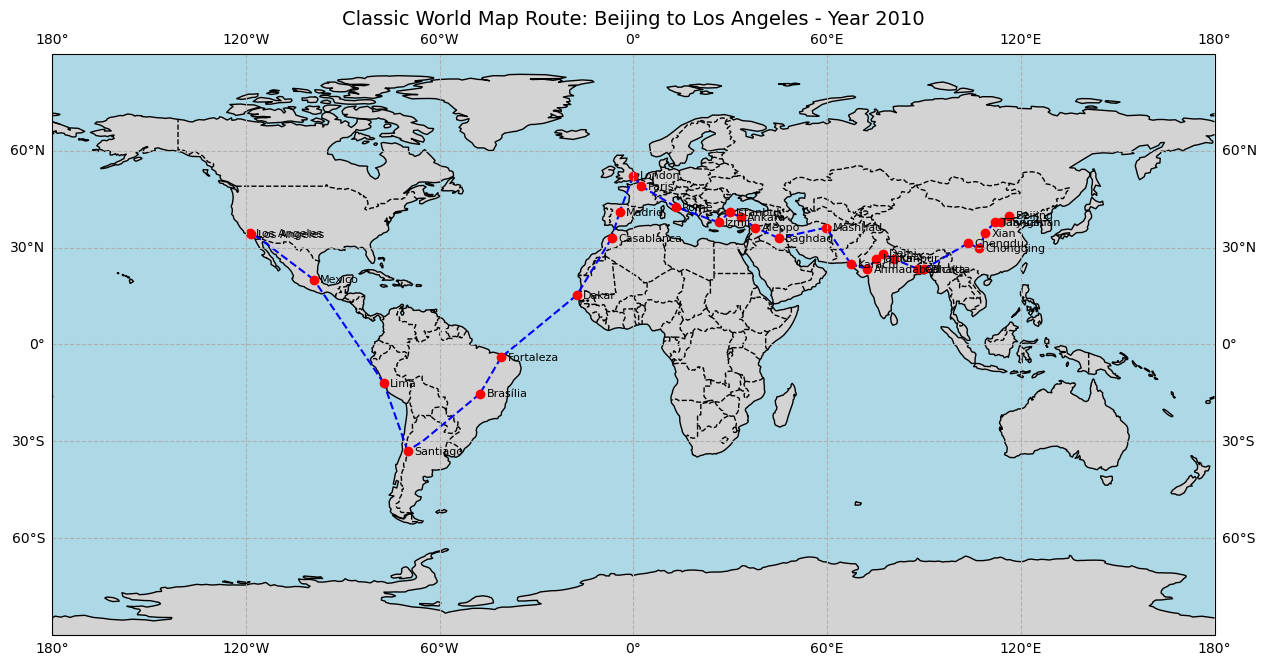

In [8]:
# Weather Project
# Python Project PART 2: Warmest Route Calculation

# Import necessary libraries
import pandas as pd
import geopandas as gpd  # Non utilizzato nel codice ma incluso
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
data1 = pd.read_csv("C:\\Users\\39392\\Desktop\\DSE\\1ST YEAR\\PYTHON\\projectpython\\weather_project\\data\\GlobalLandTemperaturesByMajorCity.csv")

# Data Cleaning
data1_cleaned = data1.dropna(subset=['AverageTemperature', 'AverageTemperatureUncertainty']).copy()

# Convert 'dt' column to datetime
data1_cleaned['dt'] = pd.to_datetime(data1_cleaned['dt'], errors='coerce')

# Convert latitude and longitude to numeric values
data1_cleaned['Latitude'] = data1_cleaned['Latitude'].apply(
    lambda x: float(x[:-1]) * (-1 if 'S' in x or 'W' in x else 1)
)
data1_cleaned['Longitude'] = data1_cleaned['Longitude'].apply(
    lambda x: float(x[:-1]) * (-1 if 'S' in x or 'W' in x else 1)
)

# Extract year from the 'dt' column
data1_cleaned['Year'] = data1_cleaned['dt'].dt.year

# Starting and ending cities
start_city = {'City': 'Beijing', 'Latitude': 39.9042, 'Longitude': 116.4074}
end_city = {'City': 'Los Angeles', 'Latitude': 34.0522, 'Longitude': -118.2437}

# Define helper functions
def calculate_distance(coord1, coord2):
    """
    Calculate the geodetic distance between two coordinates.
    """
    return geodesic(coord1, coord2).kilometers

def calculate_warmest_route(data1, start_coords, end_coords):
    """
    Calculate the route from Beijing to Los Angeles, choosing the warmest city among the 3 closest cities to the west.
    
    :param data1: DataFrame with city temperature data
    :param start_coords: Coordinates of the starting city (latitude, longitude)
    :param end_coords: Coordinates of the ending city (latitude, longitude)
    :return: List of the route with information on visited cities
    """
    current_coords = start_coords
    route = [{'City': 'Beijing', 'Latitude': start_coords[0], 'Longitude': start_coords[1], 'AverageTemperature': None}]
    data_copy = data1.copy()
    
    while True:
        if data_copy.empty:
            print("No cities available for calculation. Stopping.")
            break

        # Calculate distances and filter cities to the west of the current city
        data_copy['Distance'] = data_copy.apply(
            lambda row: calculate_distance(current_coords, (row['Latitude'], row['Longitude'])), axis=1
        )
        data_copy['DistanceToEnd'] = data_copy.apply(
            lambda row: calculate_distance((row['Latitude'], row['Longitude']), end_coords), axis=1
        )
        data_copy = data_copy[data_copy['Longitude'] < current_coords[1]]  # Only cities to the west

        if data_copy.empty:
            print("No cities to the west found. Stopping.")
            break

        # Select the 3 closest cities
        closest_cities = data_copy.nsmallest(3, 'Distance')

        if closest_cities.empty:
            print("No close cities found. Stopping.")
            break

        # Find the warmest city among these
        warmest_city = closest_cities.sort_values(by='AverageTemperature', ascending=False).iloc[0]

        # Add the city to the route
        route.append({
            'City': warmest_city['City'],
            'Latitude': warmest_city['Latitude'],
            'Longitude': warmest_city['Longitude'],
            'AverageTemperature': warmest_city['AverageTemperature']
        })

        # Update the current position
        current_coords = (warmest_city['Latitude'], warmest_city['Longitude'])

        # Stop if we are close to Los Angeles
        if calculate_distance(current_coords, end_coords) < 100:  # Threshold for "close"
            route.append({
                'City': 'Los Angeles',
                'Latitude': end_coords[0],
                'Longitude': end_coords[1],
                'AverageTemperature': None
            })
            break

        # Remove the visited city from the dataset
        data_copy = data_copy[data_copy['City'] != warmest_city['City']]

    return route

# Prompt the user for a year and filter the dataset
year = int(input("Select a year between 1743 and 2013: "))
filtered_data1 = data1_cleaned[data1_cleaned['Year'] == year]

# Calculate the route
route = calculate_warmest_route(
    filtered_data1,
    start_coords=(start_city['Latitude'], start_city['Longitude']),
    end_coords=(end_city['Latitude'], end_city['Longitude'])
)

# Display the route
print("\nCalculated Route:")
for step in route:
    print(step)

# Plot the route on a Europe-centered map
def plot_classic_world_map_route(route):
    """
    Display the calculated route on a classic world map centered on Europe.
    """
    # Extract route coordinates
    lons = [step['Longitude'] for step in route]
    lats = [step['Latitude'] for step in route]
    cities = [step['City'] for step in route]

    # Create the map figure
    fig, ax = plt.subplots(
        figsize=(15, 10),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')

    # Plot the route
    for i in range(len(lons) - 1):
        ax.plot(
            [lons[i], lons[i + 1]], [lats[i], lats[i + 1]],
            color='blue', linestyle='--', linewidth=1.5,
            transform=ccrs.Geodetic()
        )

    # Plot the city points
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'ro', transform=ccrs.PlateCarree())
        ax.text(lon + 2, lat - 1, city, fontsize=8, transform=ccrs.PlateCarree())

    # Set title and map limits
    ax.set_title(f"Classic World Map Route: Beijing to Los Angeles - Year {year}", fontsize=14)
    ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Full world extent
    ax.gridlines(draw_labels=True, linestyle='--')

    # Show the map
    plt.show()

# Display the route on the map
plot_classic_world_map_route(route)
